### 2D Example for Operator Learning in TorchPhysics

Now we want to handle a more complicated PDE, the Allen-Cahn equation:
\begin{align*}
    \epsilon \Delta u + (u^3-u)&= f &&\text{ in } \Omega, \\
    n \cdot \nabla u &= 0 &&\text{ on } \partial \Omega.
\end{align*}
As before, the goal is to train one network that outputs $u$ for a given $f$. 

We will use at first a default FCN that gets a discretized $f$ as an input and outputs the solution $u$ (also on a discrete grid)

In [ ]:
# This block is for GPU selection. Please execute.
import pathlib
import os
user = int(str(pathlib.Path().resolve())[22:24])
os.environ["CUDA_VISIBLE_DEVICES"]= str(user % 4)

import torch 
import torchphysics as tp
import pytorch_lightning as pl
import matplotlib.pyplot as plt

Given that we still work with a data-driven approach we first have to load some data.

In [2]:
save_path = "/localdata/komso/datasets/AllenCahn_data"
input_f = torch.load(f"{save_path}/input_data.pt")
output_u = torch.load(f"{save_path}/output_data.pt")

print("Space discretization:", input_f.shape[1:3])
print("Available data points:", len(input_f))
print("Shape of data:", input_f.shape)

Space discretization: torch.Size([64, 64])
Available data points: 20000
Shape of data: torch.Size([20000, 64, 64, 1])


Next, we can have a look at one example of our data set.

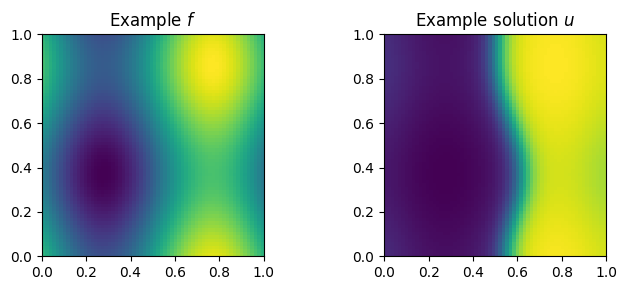

In [3]:
# Plot one example of the data
plot_idx = 12

f, axarr = plt.subplots(1, 2, figsize=(7, 3))
axarr[0].imshow(input_f[plot_idx, :, :].reshape(64, 64), origin='lower', extent=[0,1,0,1])
axarr[0].title.set_text(r"Example $f$")
axarr[1].imshow(output_u[plot_idx, :, :].reshape(64, 64), origin='lower', extent=[0,1,0,1])
axarr[1].title.set_text(r"Example solution $u$")
plt.tight_layout()

In [4]:
# Flatten the space grid to make them compatible with a FCN which can only work on one dimension of the tensor!
input_f = input_f.flatten(start_dim=1, end_dim=2)
output_u = output_u.flatten(start_dim=1, end_dim=2)

in_discretization = input_f.shape[1]
out_discretization = output_u.shape[1]

Next we implement the *Spaces* that appear in the problem. Now we have additional *FunctionSpaces* defining what kind of functions appear in the problem.

In [ ]:
X = ... # TODO: Define the two-dimensional space for x
F = ... # TODO: Also add the one-dimensional space for f and u
U = ...

# TODO: Create the functionspaces from X -> F and X -> U
fn_space_F = tp.spaces.FunctionSpace(..., ...)
fn_space_U = ...

We split our data into training and testing set. Such that we only train on one part of the data and afterwards can validate our model on the unseen testing set.

In [ ]:
# Split data into training and testing:
total_data = len(input_f)
train_N = int(0.8*total_data) # we use 80% of the data for training

# Slice the tensor to get the training data:
train_f = ...
train_u = ...

test_f = input_f[train_N:]
test_u = output_u[train_N:]

# TODO: Define FunctionSets to handle data collection
data_functionset_input = tp.domains.DataFunctionSet(..., ...)
data_functionset_output = ...

We marked what data belongs to what space, now we also create an object that selects some samples from our data and passes it to our model for training.
This is done by the *FunctionSampler*-class. They are comparable to the *Samplers* from before.

In [ ]:
# TODO: Create the samplers:
functionsampler_input = tp.samplers.FunctionSamplerRandomUniform(..., ...)
functionsampler_output = tp.samplers.FunctionSamplerCoupled(..., ...)

Now we define our neural network that should learn the operator. As explained we use a FCN mapping $f$ (on the time grid) to $u$ (on the same grid).

In [ ]:
# TODO: Build the "Operator_FCN", where we want to use 3 hidden layers with 500 neurons each
model = tp.models.Operator_FCN(input_fn_space=..., 
                               output_fn_space=..., 
                               in_discretization=in_discretization, 
                               out_discretization=out_discretization,
                               hidden=...)

For the training we again need to define a condition that defines what model should learn what kind of equation. Since we are only working with a data-driven learning objective, this is quite simple here.
The *OperatorCondition* will plug the data $X_i$ provided from one sampler into the model and compares the output $u_\theta(X_i)$ with the data $Y_i$ of the second sampler by computing the mean squared error:
\begin{align*}
    \frac{1}{N}\sum_{i=1}^N \|u_\theta(X_i) - Y_i\|^2
\end{align*}

In [ ]:
# TODO: Complete the OperatorCondition
data_condition = tp.conditions.OperatorCondition(module=..., 
                                                 input_function_sampler=..., 
                                                 output_function_sampler=...)

Start the training. Where we now also add a *learning rate scheduler* to decrease the learning rate after a given number of steps.

In [ ]:
lr_scheduler = torch.optim.lr_scheduler.StepLR

optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=0.005,
                            scheduler_class=lr_scheduler, 
                            scheduler_args={"step_size": 3000, "gamma":0.25})

# As before define the solver and trainer:
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.callbacks.progress.rich_progress import RichProgressBarTheme
solver = tp.solver.Solver([data_condition], optimizer_setting=optim)

trainer = pl.Trainer(devices=1, accelerator="gpu",
                    num_sanity_val_steps=0,
                    benchmark=True,
                    max_steps=20000, 
                    logger=False, 
                    callbacks=[RichProgressBar(refresh_rate=20, theme=RichProgressBarTheme(metrics= "black", metrics_format='.7f'))], # show training process
                    enable_checkpointing=False)

trainer.fit(solver)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [7]
/home/tomfre/miniconda3/envs/tp_version2/lib/python3.11/site-packages/pytorch_lightning/core/optimizer.py:256: Found unsupported keys in the lr scheduler dict: {'gamma', 'step_size'}. HINT: remove them from the output of `configure_optimizers`.

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 4.6 M 
1 | val_conditions   | ModuleList | 0     
-------------------------

Epoch 0: 100%|██████████| 20000/20000 [03:57<00:00, 84.06it/s, train/loss=0.000231]

`Trainer.fit` stopped: `max_steps=20000` reached.


Epoch 0: 100%|██████████| 20000/20000 [03:57<00:00, 84.06it/s, train/loss=0.000231]


Finally, we check the performance on the test data (which the model has not seen before!).

In [ ]:
model.cpu()
model_output = model(tp.spaces.Points(test_f, F)).as_tensor.detach()
rel_error = torch.norm(model_output - test_u, p=2, dim=(1,2))
rel_error /= torch.norm(test_u, p=2, dim=(1,2))

rel_error = torch.mean(torch.sqrt(rel_error))

print(f"Mean Relative error on test data: {rel_error*100}%")

We can also visualize the performance:

In [ ]:
# Plot one example of the test data
plot_idx = 1260

f, axarr = plt.subplots(1, 4, figsize=(12, 3))

vmin, vmax = torch.min(test_u[plot_idx]), torch.max(test_u[plot_idx])

img = axarr[0].imshow(test_f[plot_idx, :, :].reshape(64, 64), origin='lower', extent=[0,1,0,1])
axarr[0].title.set_text(r"Input $f$")
plt.colorbar(img, ax=axarr[0], shrink=0.75)

img =axarr[1].imshow(test_u[plot_idx, :, :].reshape(64, 64), vmin=vmin, vmax=vmax, origin='lower', extent=[0,1,0,1])
axarr[1].title.set_text(r"Expected $u$")
plt.colorbar(img, ax=axarr[1], shrink=0.75)

img =axarr[2].imshow(model_output[plot_idx, :, :].reshape(64, 64), vmin=vmin, vmax=vmax, origin='lower', extent=[0,1,0,1])
axarr[2].title.set_text(r"Predicted $u$")
plt.colorbar(img, ax=axarr[2], shrink=0.75)

img = axarr[3].imshow(torch.abs(model_output[plot_idx, :, :]-test_u[plot_idx, :, :]).reshape(64, 64), 
                cmap="jet", origin='lower', extent=[0,1,0,1])

axarr[3].title.set_text(r"Difference")
plt.colorbar(img, ax=axarr[3], shrink=0.75)

plt.tight_layout()